In [1]:
import os
import sys
sys.path.append('../')

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from TFRHelper import *

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature2(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def get_features(dt):
    img = dt['image']
    landmarks_3d = dt['landmarks_68_3d_xy_normalized']

    img_h, img_w, _  = img.shape

    all_landmarks = np.multiply(landmarks_3d, [img_h, img_w])
    
    face_bbox = get_face_roi2(img, all_landmarks, 192, 192, 1.0)
    face = crop_image(img, face_bbox)

    landmarks = get_new_landmark(all_landmarks, face_bbox)

    h, w, c = face.shape
    if h > w:
        padding = (h - w) // 2
        face = cv2.copyMakeBorder(face, 0, 0, padding, padding, cv2.BORDER_REPLICATE)
        landmarks = landmarks + [padding, 0]
    if w > h:
        padding = (w - h) // 2
        face = cv2.copyMakeBorder(face, padding, padding, 0, 0, cv2.BORDER_REPLICATE)
        landmarks = landmarks + [0, padding]
    
    if not is_img_valid(face):
        return None

    normed_landmark = landmarks / face.shape[:2]
    face = cv2.resize(face, (192, 192))

    # Headpose Estimation
    f = img_w
    c = (img_w / 2, img_h / 2)
    
    required_landmarks = get_required_landmarks(landmarks)
    image_points_2d = get2DImagePoints(required_landmarks)
    rvec, tvec = getRVec(image_points_2d, f, c)

    rmat = cv2.Rodrigues(rvec)[0]

    if tvec[-1] < 0:
        rmat[:,1:] = rmat[:,1:] * -1 # note: for some reason, solvePnP fails to find solution on positive z-axis.
    hp = rotationMatrixToEulerAngles(rmat)

    return face, normed_landmark, hp

def encode_features(feature):
    face, to_save_landmark, hp = feature
    encoded_face = tf.io.encode_jpeg(face, quality=100).numpy() 
    
    feature = {
        'image': _bytes_feature(encoded_face),
        'landmarks': _float_feature(np.reshape(to_save_landmark, (-1)).tolist()),
        'headpose': _float_feature(np.reshape(hp, (-1)).tolist())
    }
    
    return feature

In [16]:
ds = tfds.load('aflw2k3d', split='train')
iterator = ds.as_numpy_iterator()

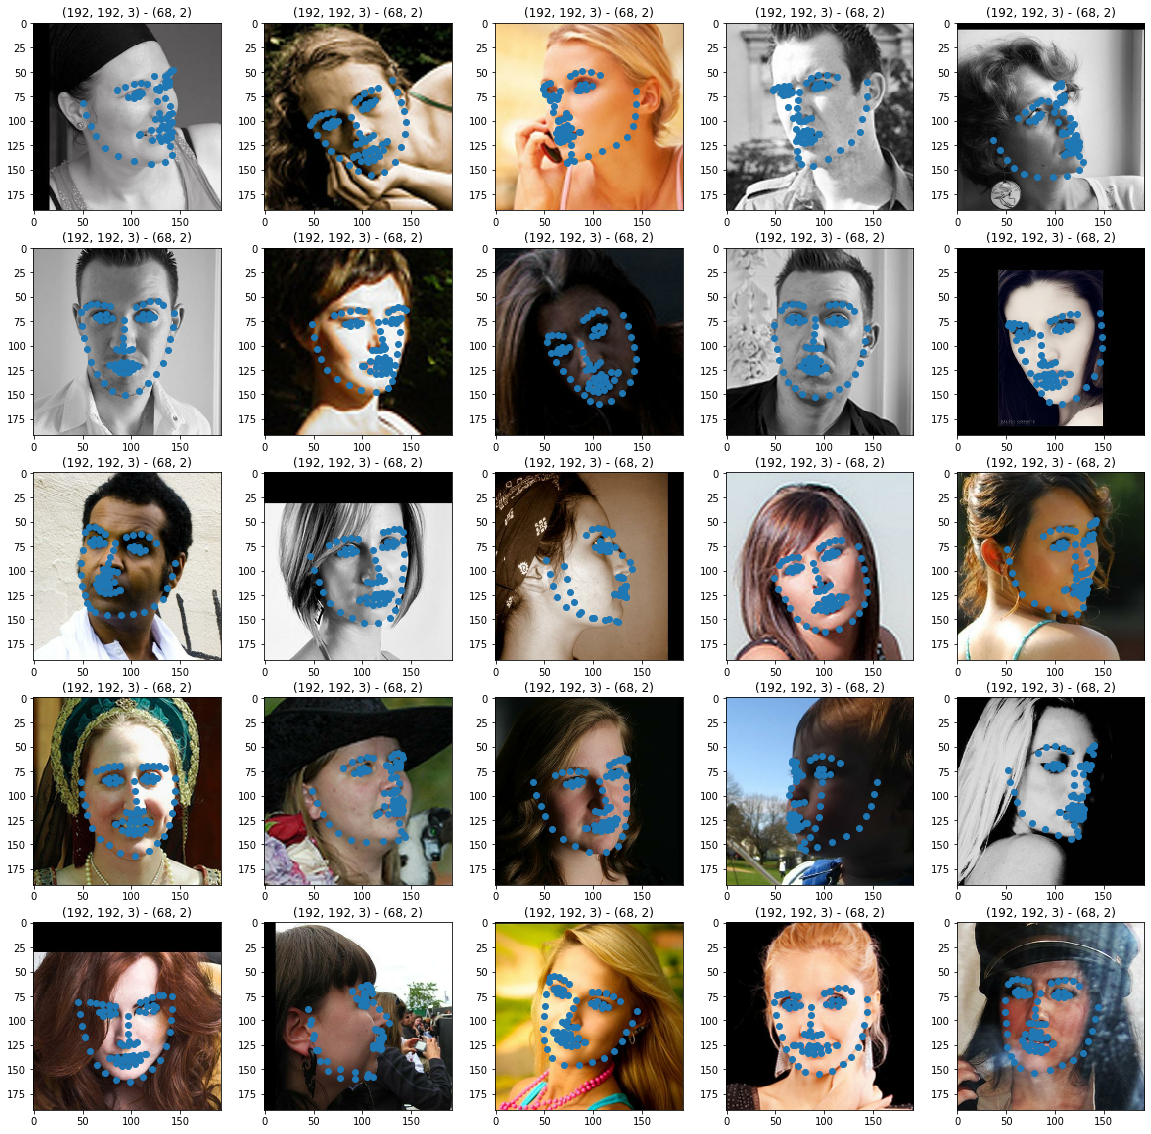

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25):
    dt = iterator.next()
    feature = get_features(dt)

    if feature == None:
        continue
        
    face, landmarks, hp = feature
    
    h, w, c = face.shape
    landmarks = landmarks * [w, h]
    x, y = np.transpose(landmarks)
    
    axes[i//5][i%5].scatter(x, y)
    axes[i//5][i%5].imshow(face)
    axes[i//5][i%5].set_title(f'{face.shape} - {landmarks.shape}')

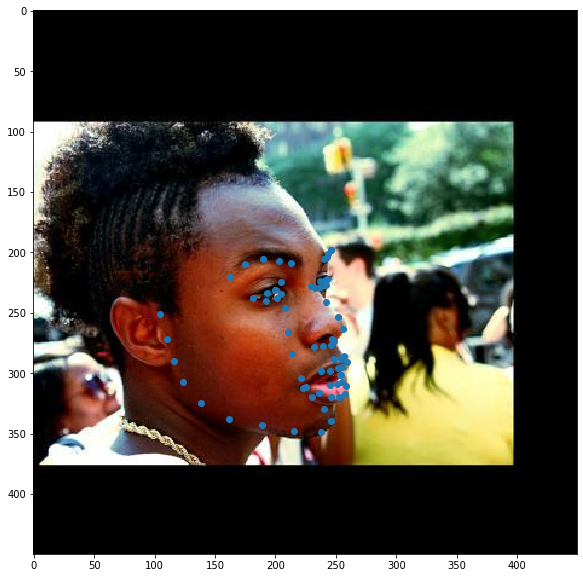

In [9]:
dt = iterator.next()

image = dt['image']
xy = dt['landmarks_68_3d_xy_normalized']
z = dt['landmarks_68_3d_z']

h, w, c = image.shape
xy = xy * [w, h]

# landmarks = get_required_landmarks(xy)

x, y = np.transpose(xy) 

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.scatter(x, y)